# Comparação de Modelos para Classificação de Comportamentos

Comparação de modelos de Deep Learning usando 3 tipos de janelas temporais.


In [18]:
# Verificação de dependências
try:
    import torch
    import torch.nn as nn
    from torch.utils.data import Dataset, DataLoader
    print(f"✅ PyTorch {torch.__version__} instalado")
except ImportError:
    print("❌ PyTorch não instalado. Execute: pip install torch")
    raise

import numpy as np
import pandas as pd
import polars as pl
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")


✅ PyTorch 2.9.1+cu128 instalado
Device: cuda


## 1. Datasets


In [41]:
class ForwardLookingDataset(Dataset):
    """idx + 99 para frente (100 amostras)"""
    def __init__(self, data, labels, calf_ids, window_size=100):
        self.signals = np.array(data, dtype='float32')
        self.labels = np.array(labels, dtype='int64')
        self.calf_ids = np.array(calf_ids) if not isinstance(calf_ids, np.ndarray) else calf_ids
        self.valid_indices = list(range(len(data) - window_size + 1))

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        start = self.valid_indices[idx]
        x = self.signals[start:start+100]
        y = self.labels[start]
        return torch.tensor(x).permute(1, 0), torch.tensor(y, dtype=torch.long)

    def get_calf_id(self, idx):
        """Retorna o calfId do índice"""
        return self.calf_ids[self.valid_indices[idx]]


class BackwardLookingDataset(Dataset):
    """99 anteriores + idx (100 amostras)"""
    def __init__(self, data, labels, calf_ids, window_size=100):
        self.signals = np.array(data, dtype='float32')
        self.labels = np.array(labels, dtype='int64')
        self.calf_ids = np.array(calf_ids) if not isinstance(calf_ids, np.ndarray) else calf_ids
        self.window_size = window_size

        # Verificar se signals e labels têm o mesmo tamanho
        if len(self.signals) != len(self.labels):
            raise ValueError(f"signals e labels devem ter o mesmo tamanho: signals={len(self.signals)}, labels={len(self.labels)}")

        # valid_indices contém os índices globais válidos (window_size-1 até len(data)-1)
        self.valid_indices = list(range(window_size-1, len(data)))

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        # idx é sempre relativo ao dataset (0 a len(dataset)-1)
        # valid_indices contém os índices globais válidos
        if idx >= len(self.valid_indices):
            raise IndexError(f"Index {idx} out of range for dataset of size {len(self.valid_indices)}")

        # Obter o índice global correspondente
        end = self.valid_indices[idx]

        # Verificar bounds para signals
        if end >= len(self.signals) or end < self.window_size - 1:
            raise IndexError(f"Index {end} out of bounds for signals of size {len(self.signals)}")

        # Verificar bounds para labels
        if end >= len(self.labels):
            raise IndexError(f"Index {end} out of bounds for labels of size {len(self.labels)}")

        x = self.signals[end-99:end+1]
        y = self.labels[end]
        return torch.tensor(x).permute(1, 0), torch.tensor(y, dtype=torch.long)

    def get_calf_id(self, idx):
        """Retorna o calfId do índice"""
        # idx é sempre relativo ao dataset (0 a len(dataset)-1)
        if idx >= len(self.valid_indices):
            raise IndexError(f"Index {idx} out of range for dataset of size {len(self.valid_indices)}")
        end = self.valid_indices[idx]
        return self.calf_ids[end]


class BidirectionalDataset(Dataset):
    """50 anteriores + idx + 49 à frente (100 amostras)"""
    def __init__(self, data, labels, calf_ids, lookback=50, lookforward=49):
        self.signals = np.array(data, dtype='float32')
        self.labels = np.array(labels, dtype='int64')
        self.calf_ids = np.array(calf_ids) if not isinstance(calf_ids, np.ndarray) else calf_ids
        self.lookback = lookback
        self.lookforward = lookforward
        self.valid_indices = list(range(lookback, len(data) - lookforward))

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        center = self.valid_indices[idx]
        x = self.signals[center-50:center+50]
        y = self.labels[center]
        return torch.tensor(x).permute(1, 0), torch.tensor(y, dtype=torch.long)

    def get_calf_id(self, idx):
        """Retorna o calfId do índice"""
        return self.calf_ids[self.valid_indices[idx]]


## 2. Modelos


In [20]:
class LSTM_Model(nn.Module):
    def __init__(self, input_size=3, hidden_size=128, num_classes=50):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (B, C, T) -> (B, T, C)
        out, (h_n, c_n) = self.lstm(x)
        out = self.fc(h_n[-1])
        return out


class CNN1D_Model(nn.Module):
    def __init__(self, num_classes=50):
        super().__init__()
        self.conv1 = nn.Conv1d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(256, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.pool(x).squeeze(-1)
        x = self.fc(x)
        return x


class CNN2D_Model(nn.Module):
    def __init__(self, num_classes=50):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=(3, 3), padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3, 3), padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(3, 3), padding=1)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(256, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.unsqueeze(1)  # (B, 3, 100) -> (B, 1, 3, 100)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.pool(x).squeeze(-1).squeeze(-1)
        x = self.fc(x)
        return x


class CNN_LSTM_Model(nn.Module):
    def __init__(self, num_classes=50):
        super().__init__()
        self.conv1 = nn.Conv1d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.lstm = nn.LSTM(128, 128, batch_first=True)
        self.fc = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = x.permute(0, 2, 1)  # (B, C, T) -> (B, T, C)
        out, (h_n, c_n) = self.lstm(x)
        x = self.fc(h_n[-1])
        return x


## 3. Carregamento dos Dados


In [ ]:
# Carregar dados usando Polars (mais eficiente para arquivos grandes)
print("Carregando dados rotulados...")
df_pl = pl.read_parquet('AcTBeCalf.parquet')

# Converter para Pandas para análises e visualizações
df = df_pl.to_pandas()

signals = df[['accX', 'accY', 'accZ']].values
calf_ids = df['calfId'].values

cats = sorted(df['behaviour'].unique())
label_map = {label: i for i, label in enumerate(cats)}
labels = np.array(df['behaviour'].map(label_map).values, dtype='int64')

# Verificar se têm o mesmo tamanho
assert len(signals) == len(labels), f"Erro: signals ({len(signals)}) e labels ({len(labels)}) devem ter o mesmo tamanho!"
assert len(signals) == len(calf_ids), f"Erro: signals ({len(signals)}) e calf_ids ({len(calf_ids)}) devem ter o mesmo tamanho!"
print(f"✅ Verificação: signals, labels e calf_ids têm {len(signals):,} elementos cada")

num_classes = len(cats)
unique_calves = sorted(df['calfId'].unique())
num_calves = len(unique_calves)

print(f"✅ Dados carregados com sucesso!")
print(f"📊 Dimensões: {len(df):,} amostras, {num_classes} classes")
print(f"🐄 Bezerros: {num_calves} bezerros únicos")
print(f"📋 Bezerros: {unique_calves}")


Carregando dados rotulados...
✅ Dados carregados com sucesso!
📊 Dimensões: 2,467,162 amostras, 50 classes
🐄 Bezerros: 30 bezerros únicos
📋 Bezerros: ['1302', '1303', '1306', '1308', '1312', '1314', '1319', '1320', '1328', '1329', '1333', '1335', '1336', '1343', '1351', '1353', '1357', '1372', '1398', '1403', '1405', '1408', '1409', '1416', '1433', '1443', '1444', '1449', '1452', '1455']


## 4. Configuração de Split por Bezerro


In [ ]:
# Configuração do split por bezerro
# Modo 1: 22 treino, 4 val, 4 teste (padrão)
# Modo 2: 8 treino, 2 val, 2 teste (alternativo)
SPLIT_MODE = 2  # Mude para 2 para usar o modo alternativo

if SPLIT_MODE == 1:
    N_TRAIN = 22
    N_VAL = 4
    N_TEST = 4
    print("📊 Modo 1: 22 treino, 4 validação, 4 teste")
else:
    N_TRAIN = 3
    N_VAL = 1
    N_TEST = 1
    print("📊 Modo 2: 8 treino, 2 validação, 2 teste")

def split_by_calf(dataset, unique_calves, n_train, n_val, n_test, random_state=42):
    """
    Divide os bezerros em conjuntos de treino, validação e teste.
    Retorna os índices do dataset correspondentes a cada conjunto.
    """
    np.random.seed(random_state)
    shuffled_calves = np.random.permutation(unique_calves)

    train_calves = shuffled_calves[:n_train]
    val_calves = shuffled_calves[n_train:n_train+n_val]
    test_calves = shuffled_calves[n_train+n_val:n_train+n_val+n_test]

    print(f"\n🐄 Split por Bezerro:")
    print(f"  Treino: {sorted(train_calves)} ({len(train_calves)} bezerros)")
    print(f"  Validação: {sorted(val_calves)} ({len(val_calves)} bezerros)")
    print(f"  Teste: {sorted(test_calves)} ({len(test_calves)} bezerros)")

    # Encontrar índices do dataset para cada bezerro
    # IMPORTANTE: Os índices devem ser relativos ao dataset (0 a len(dataset)-1)
    train_indices = []
    val_indices = []
    test_indices = []

    # Iterar apenas sobre os índices válidos do dataset
    for idx in range(len(dataset)):
        try:
            # Verificar se o índice é válido antes de acessar
            if idx >= len(dataset):
                continue
            calf_id = dataset.get_calf_id(idx)
            if calf_id in train_calves:
                train_indices.append(idx)
            elif calf_id in val_calves:
                val_indices.append(idx)
            elif calf_id in test_calves:
                test_indices.append(idx)
        except (IndexError, KeyError, AttributeError) as e:
            # Pular índices inválidos
            continue

    print(f"\n📊 Amostras por conjunto:")
    print(f"  Treino: {len(train_indices):,} amostras")
    print(f"  Validação: {len(val_indices):,} amostras")
    print(f"  Teste: {len(test_indices):,} amostras")

    return train_indices, val_indices, test_indices

def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            outputs = model(x)
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y.numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    f1_weighted = f1_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)
    return acc, f1_macro, f1_weighted, cm, all_preds, all_labels


def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()


📊 Modo 2: 8 treino, 2 validação, 2 teste


## 5. Funções de Treinamento


In [ ]:
from sklearn.metrics import f1_score

def train_model(model, train_loader, val_loader, epochs=10, lr=0.001):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # # Coloca um scheduler forte para baixar bem o learning rate
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
    #                                                        mode='min',
    #                                                        factor=0.2,
    #                                                        patience=2,
    #                                                        min_lr=1e-6)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        val_preds = []
        val_targets = []
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                outputs = model(x)
                loss = criterion(outputs, y)

                #acuracia
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += y.size(0)
                correct += predicted.eq(y).sum().item()

                #f1
                val_preds.extend(predicted.cpu().numpy())
                val_targets.extend(y.cpu().numpy())

        val_f1 = f1_score(val_targets, val_preds, average="macro")
        val_f1_weighted = f1_score(val_targets, val_preds, average="weighted")

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss/len(train_loader):.4f}, Val Acc: {100*correct/total:.2f}%, Val F1-macro: {val_f1:.4f}, Val F1-weighted: {val_f1_weighted:.4f}")

        # # Scheduler step baseado no val_loss
        # scheduler.step(val_loss)

    return model


def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            outputs = model(x)
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y.numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    f1_weighted = f1_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)
    return acc, f1_macro, f1_weighted, cm, all_preds, all_labels


def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(12, 10))
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues')
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()


## 6. Forward-Looking Dataset


In [24]:
dataset_forward = ForwardLookingDataset(signals, labels, calf_ids)
train_idx, val_idx, test_idx = split_by_calf(dataset_forward, unique_calves, N_TRAIN, N_VAL, N_TEST)

train_dataset = torch.utils.data.Subset(dataset_forward, train_idx)
val_dataset = torch.utils.data.Subset(dataset_forward, val_idx)
test_dataset = torch.utils.data.Subset(dataset_forward, test_idx)

train_loader = DataLoader(train_dataset, batch_size=1280, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1280, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1280, shuffle=False)

results_forward = {}



🐄 Split por Bezerro:
  Treino: [np.str_('1353'), np.str_('1416'), np.str_('1449')] (3 bezerros)
  Validação: [np.str_('1372')] (1 bezerros)
  Teste: [np.str_('1328')] (1 bezerros)

📊 Amostras por conjunto:
  Treino: 126,662 amostras
  Validação: 61,526 amostras
  Teste: 50,114 amostras



LSTM - Forward
Epoch 1/20 - Train Loss: 2.3116, Val Acc: 17.04%, Val F1-macro: 0.0170, Val F1-weighted: 0.0673
Epoch 2/20 - Train Loss: 1.9460, Val Acc: 22.40%, Val F1-macro: 0.0407, Val F1-weighted: 0.1557
Epoch 3/20 - Train Loss: 1.6949, Val Acc: 21.79%, Val F1-macro: 0.0387, Val F1-weighted: 0.1399
Epoch 4/20 - Train Loss: 1.8763, Val Acc: 18.03%, Val F1-macro: 0.0187, Val F1-weighted: 0.0699
Epoch 5/20 - Train Loss: 1.7956, Val Acc: 18.30%, Val F1-macro: 0.0231, Val F1-weighted: 0.0865
Epoch 6/20 - Train Loss: 1.5395, Val Acc: 31.57%, Val F1-macro: 0.0676, Val F1-weighted: 0.2344
Epoch 7/20 - Train Loss: 1.3366, Val Acc: 36.21%, Val F1-macro: 0.0915, Val F1-weighted: 0.2937
Epoch 8/20 - Train Loss: 1.1908, Val Acc: 36.49%, Val F1-macro: 0.0949, Val F1-weighted: 0.3013
Epoch 9/20 - Train Loss: 1.1269, Val Acc: 37.87%, Val F1-macro: 0.1049, Val F1-weighted: 0.3275
Epoch 10/20 - Train Loss: 1.0418, Val Acc: 34.17%, Val F1-macro: 0.0965, Val F1-weighted: 0.2991
Epoch 11/20 - Train Los

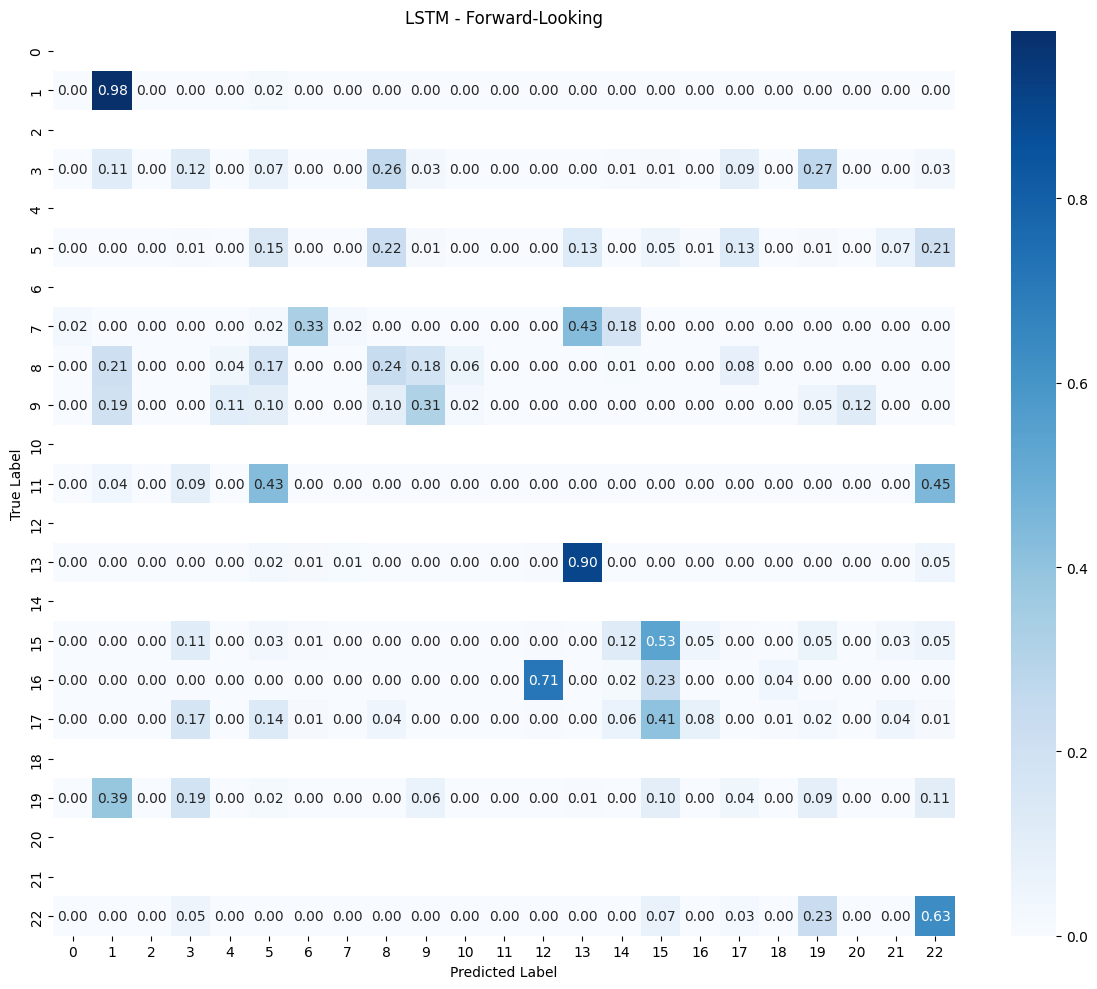

In [26]:
# LSTM - Forward-Looking
print("\nLSTM - Forward")
model_lstm_forward = LSTM_Model(num_classes=num_classes)
trained_model = train_model(model_lstm_forward, train_loader, val_loader, epochs=20, lr=0.01)
acc, f1_macro, f1_weighted, cm, preds, labels = evaluate_model(trained_model, test_loader)
results_forward['LSTM'] = {'acc': acc, 'f1_macro': f1_macro, 'f1_weighted': f1_weighted, 'cm': cm}
print(f"Test Accuracy: {acc*100:.2f}%")
print(f"F1-Macro: {f1_macro*100:.2f}%")
print(f"F1-Weighted: {f1_weighted*100:.2f}%")
plot_confusion_matrix(cm, 'LSTM - Forward-Looking')



CNN1D - Forward
Epoch 1/20 - Train Loss: 1.4862, Val Acc: 32.04%, Val F1-macro: 0.1092, Val F1-weighted: 0.3056
Epoch 2/20 - Train Loss: 0.8950, Val Acc: 32.34%, Val F1-macro: 0.1101, Val F1-weighted: 0.2827
Epoch 3/20 - Train Loss: 0.7233, Val Acc: 41.71%, Val F1-macro: 0.1372, Val F1-weighted: 0.3961
Epoch 4/20 - Train Loss: 0.5514, Val Acc: 32.51%, Val F1-macro: 0.1188, Val F1-weighted: 0.3130
Epoch 5/20 - Train Loss: 0.4942, Val Acc: 37.86%, Val F1-macro: 0.1337, Val F1-weighted: 0.3681
Epoch 6/20 - Train Loss: 0.4143, Val Acc: 40.77%, Val F1-macro: 0.1439, Val F1-weighted: 0.3934
Epoch 7/20 - Train Loss: 0.8337, Val Acc: 32.96%, Val F1-macro: 0.1119, Val F1-weighted: 0.2928
Epoch 8/20 - Train Loss: 0.6464, Val Acc: 39.14%, Val F1-macro: 0.1296, Val F1-weighted: 0.3741
Epoch 9/20 - Train Loss: 0.4638, Val Acc: 39.02%, Val F1-macro: 0.1305, Val F1-weighted: 0.3622
Epoch 10/20 - Train Loss: 0.3810, Val Acc: 39.42%, Val F1-macro: 0.1424, Val F1-weighted: 0.3764
Epoch 11/20 - Train Lo

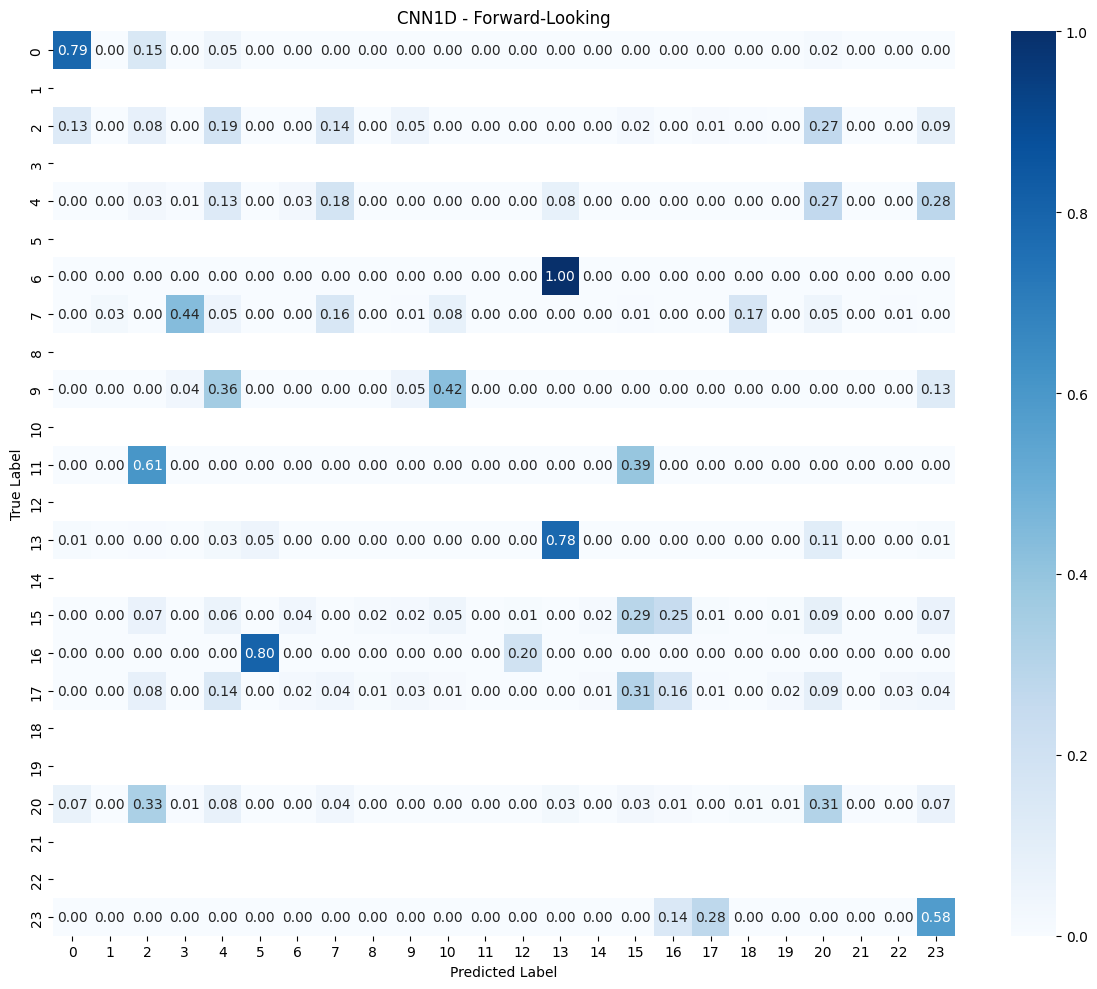

In [27]:
# CNN1D - Forward-Looking
print("\nCNN1D - Forward")
model_cnn1d_forward = CNN1D_Model(num_classes=num_classes)
trained_model = train_model(model_cnn1d_forward, train_loader, val_loader, epochs=20, lr=0.01)
acc, f1_macro, f1_weighted, cm, preds, labels = evaluate_model(trained_model, test_loader)
results_forward['CNN1D'] = {'acc': acc, 'f1_macro': f1_macro, 'f1_weighted': f1_weighted, 'cm': cm}
print(f"Test Accuracy: {acc*100:.2f}%")
print(f"F1-Macro: {f1_macro*100:.2f}%")
print(f"F1-Weighted: {f1_weighted*100:.2f}%")
plot_confusion_matrix(cm, 'CNN1D - Forward-Looking')



CNN2D - Forward
Epoch 1/20 - Train Loss: 1.6405, Val Acc: 30.69%, Val F1-macro: 0.1230, Val F1-weighted: 0.2941
Epoch 2/20 - Train Loss: 0.9347, Val Acc: 30.93%, Val F1-macro: 0.1118, Val F1-weighted: 0.2847
Epoch 3/20 - Train Loss: 0.7918, Val Acc: 37.02%, Val F1-macro: 0.1225, Val F1-weighted: 0.3522
Epoch 4/20 - Train Loss: 0.6448, Val Acc: 36.58%, Val F1-macro: 0.1241, Val F1-weighted: 0.3463
Epoch 5/20 - Train Loss: 0.5426, Val Acc: 38.66%, Val F1-macro: 0.1246, Val F1-weighted: 0.3608
Epoch 6/20 - Train Loss: 0.5011, Val Acc: 36.38%, Val F1-macro: 0.1200, Val F1-weighted: 0.3525
Epoch 7/20 - Train Loss: 0.4208, Val Acc: 39.84%, Val F1-macro: 0.1345, Val F1-weighted: 0.3896
Epoch 8/20 - Train Loss: 0.3869, Val Acc: 39.30%, Val F1-macro: 0.1259, Val F1-weighted: 0.3691
Epoch 9/20 - Train Loss: 0.4855, Val Acc: 39.18%, Val F1-macro: 0.1262, Val F1-weighted: 0.3738
Epoch 10/20 - Train Loss: 0.3423, Val Acc: 40.83%, Val F1-macro: 0.1302, Val F1-weighted: 0.3863
Epoch 11/20 - Train Lo

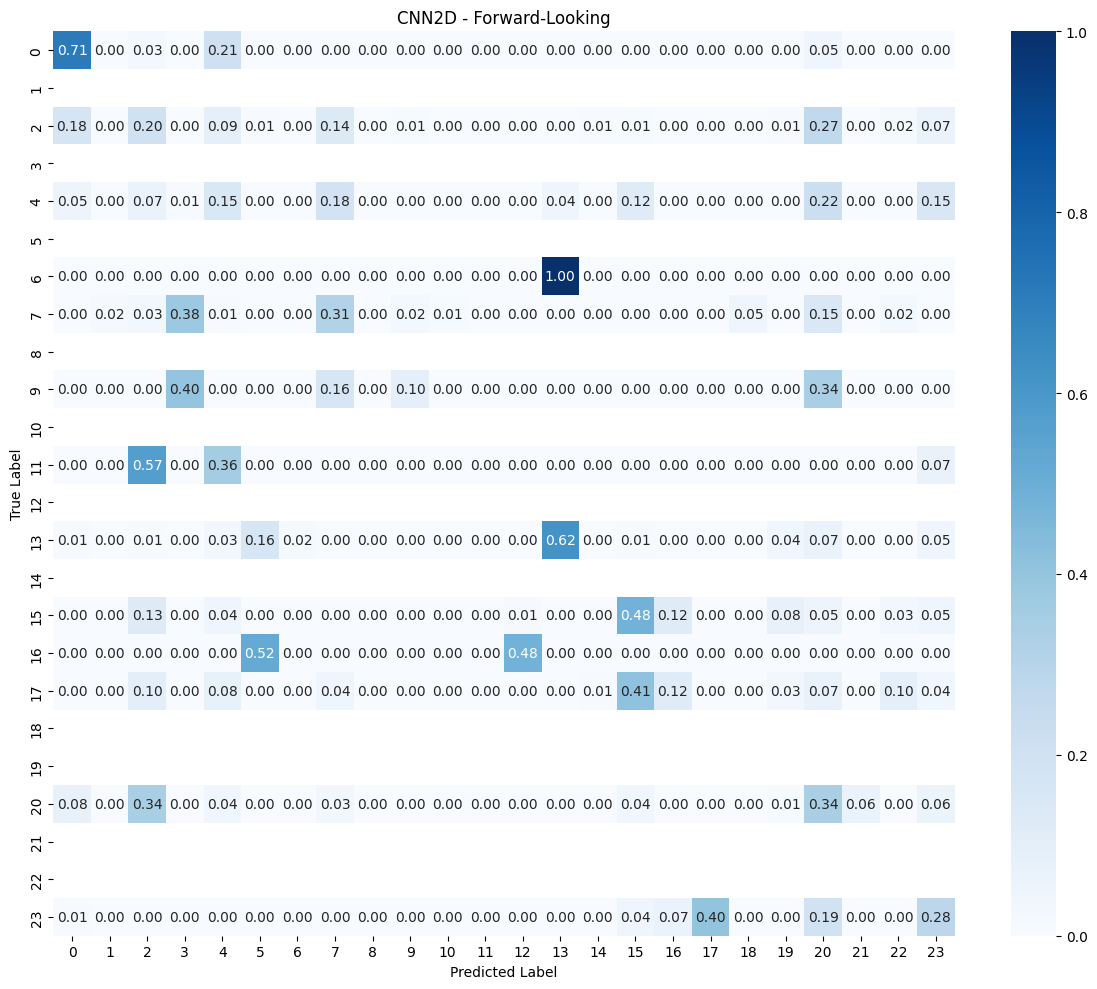

In [28]:
# CNN2D - Forward-Looking
print("\nCNN2D - Forward")
model_cnn2d_forward = CNN2D_Model(num_classes=num_classes)
trained_model = train_model(model_cnn2d_forward, train_loader, val_loader, epochs=20, lr=0.01)
acc, f1_macro, f1_weighted, cm, preds, labels = evaluate_model(trained_model, test_loader)
results_forward['CNN2D'] = {'acc': acc, 'f1_macro': f1_macro, 'f1_weighted': f1_weighted, 'cm': cm}
print(f"Test Accuracy: {acc*100:.2f}%")
print(f"F1-Macro: {f1_macro*100:.2f}%")
print(f"F1-Weighted: {f1_weighted*100:.2f}%")
plot_confusion_matrix(cm, 'CNN2D - Forward-Looking')



CNN+LSTM - Forward
Epoch 1/20 - Train Loss: 1.7625, Val Acc: 33.42%, Val F1-macro: 0.0976, Val F1-weighted: 0.2719
Epoch 2/20 - Train Loss: 0.9789, Val Acc: 36.35%, Val F1-macro: 0.1217, Val F1-weighted: 0.3323
Epoch 3/20 - Train Loss: 0.7683, Val Acc: 36.67%, Val F1-macro: 0.1193, Val F1-weighted: 0.3454
Epoch 4/20 - Train Loss: 0.5854, Val Acc: 39.53%, Val F1-macro: 0.1403, Val F1-weighted: 0.3815
Epoch 5/20 - Train Loss: 0.4501, Val Acc: 40.56%, Val F1-macro: 0.1281, Val F1-weighted: 0.3866
Epoch 6/20 - Train Loss: 0.3508, Val Acc: 37.66%, Val F1-macro: 0.1262, Val F1-weighted: 0.3856
Epoch 7/20 - Train Loss: 0.2837, Val Acc: 39.32%, Val F1-macro: 0.1361, Val F1-weighted: 0.3912
Epoch 8/20 - Train Loss: 0.2399, Val Acc: 41.07%, Val F1-macro: 0.1407, Val F1-weighted: 0.4030
Epoch 9/20 - Train Loss: 0.1742, Val Acc: 41.86%, Val F1-macro: 0.1443, Val F1-weighted: 0.4145
Epoch 10/20 - Train Loss: 0.1356, Val Acc: 40.86%, Val F1-macro: 0.1281, Val F1-weighted: 0.4056
Epoch 11/20 - Train

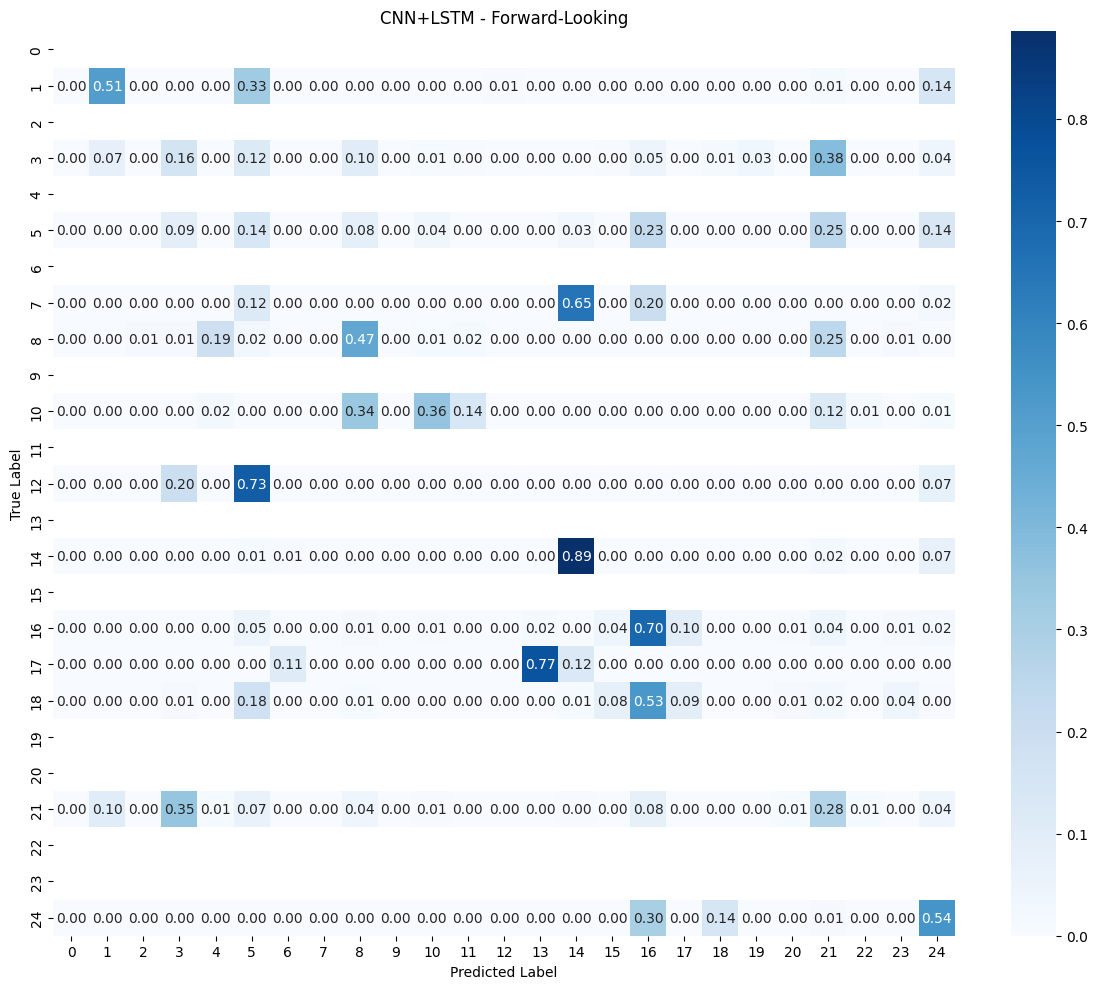

In [29]:
# CNN+LSTM - Forward-Looking
print("\nCNN+LSTM - Forward")
model_cnnlstm_forward = CNN_LSTM_Model(num_classes=num_classes)
trained_model = train_model(model_cnnlstm_forward, train_loader, val_loader, epochs=20, lr=0.01)
acc, f1_macro, f1_weighted, cm, preds, labels = evaluate_model(trained_model, test_loader)
results_forward['CNN+LSTM'] = {'acc': acc, 'f1_macro': f1_macro, 'f1_weighted': f1_weighted, 'cm': cm}
print(f"Test Accuracy: {acc*100:.2f}%")
print(f"F1-Macro: {f1_macro*100:.2f}%")
print(f"F1-Weighted: {f1_weighted*100:.2f}%")
plot_confusion_matrix(cm, 'CNN+LSTM - Forward-Looking')


## 7. Backward-Looking Dataset


In [42]:
dataset_backward = BackwardLookingDataset(signals, labels, calf_ids)
train_idx, val_idx, test_idx = split_by_calf(dataset_backward, unique_calves, N_TRAIN, N_VAL, N_TEST)

train_dataset = torch.utils.data.Subset(dataset_backward, train_idx)
val_dataset = torch.utils.data.Subset(dataset_backward, val_idx)
test_dataset = torch.utils.data.Subset(dataset_backward, test_idx)

train_loader = DataLoader(train_dataset, batch_size=1280, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=1280, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1280, shuffle=False)

results_backward = {}


ValueError: signals e labels devem ter o mesmo tamanho: signals=2467162, labels=50114

In [43]:
# LSTM - Backward-Looking
print("\nLSTM - Backward")
model_lstm_backward = LSTM_Model(num_classes=num_classes)
trained_model = train_model(model_lstm_backward, train_loader, val_loader, epochs=20, lr=0.01)
acc, f1_macro, f1_weighted, cm, preds, labels = evaluate_model(trained_model, test_loader)
results_backward['LSTM'] = {'acc': acc, 'f1_macro': f1_macro, 'f1_weighted': f1_weighted, 'cm': cm}
print(f"Test Accuracy: {acc*100:.2f}%")
print(f"F1-Macro: {f1_macro*100:.2f}%")
print(f"F1-Weighted: {f1_weighted*100:.2f}%")
plot_confusion_matrix(cm, 'LSTM - Backward-Looking')



LSTM - Backward


IndexError: index 413572 is out of bounds for axis 0 with size 50114

In [ ]:
# CNN1D - Backward-Looking
print("\nCNN1D - Backward")
model_cnn1d_backward = CNN1D_Model(num_classes=num_classes)
trained_model = train_model(model_cnn1d_backward, train_loader, val_loader, epochs=20, lr=0.01)
acc, f1_macro, f1_weighted, cm, preds, labels = evaluate_model(trained_model, test_loader)
results_backward['CNN1D'] = {'acc': acc, 'f1_macro': f1_macro, 'f1_weighted': f1_weighted, 'cm': cm}
print(f"Test Accuracy: {acc*100:.2f}%")
print(f"F1-Macro: {f1_macro*100:.2f}%")
print(f"F1-Weighted: {f1_weighted*100:.2f}%")
plot_confusion_matrix(cm, 'CNN1D - Backward-Looking')


In [ ]:
# CNN2D - Backward-Looking
print("\nCNN2D - Backward")
model_cnn2d_backward = CNN2D_Model(num_classes=num_classes)
trained_model = train_model(model_cnn2d_backward, train_loader, val_loader, epochs=20, lr=0.01)
acc, f1_macro, f1_weighted, cm, preds, labels = evaluate_model(trained_model, test_loader)
results_backward['CNN2D'] = {'acc': acc, 'f1_macro': f1_macro, 'f1_weighted': f1_weighted, 'cm': cm}
print(f"Test Accuracy: {acc*100:.2f}%")
print(f"F1-Macro: {f1_macro*100:.2f}%")
print(f"F1-Weighted: {f1_weighted*100:.2f}%")
plot_confusion_matrix(cm, 'CNN2D - Backward-Looking')


In [ ]:
# CNN+LSTM - Backward-Looking
print("\nCNN+LSTM - Backward")
model_cnnlstm_backward = CNN_LSTM_Model(num_classes=num_classes)
trained_model = train_model(model_cnnlstm_backward, train_loader, val_loader, epochs=20, lr=0.01)
acc, f1_macro, f1_weighted, cm, preds, labels = evaluate_model(trained_model, test_loader)
results_backward['CNN+LSTM'] = {'acc': acc, 'f1_macro': f1_macro, 'f1_weighted': f1_weighted, 'cm': cm}
print(f"Test Accuracy: {acc*100:.2f}%")
print(f"F1-Macro: {f1_macro*100:.2f}%")
print(f"F1-Weighted: {f1_weighted*100:.2f}%")
plot_confusion_matrix(cm, 'CNN+LSTM - Backward-Looking')


## 8. Bidirectional Dataset


In [44]:
dataset_bidirectional = BidirectionalDataset(signals, labels, calf_ids)
train_idx, val_idx, test_idx = split_by_calf(dataset_bidirectional, unique_calves, N_TRAIN, N_VAL, N_TEST)

train_dataset = torch.utils.data.Subset(dataset_bidirectional, train_idx)
val_dataset = torch.utils.data.Subset(dataset_bidirectional, val_idx)
test_dataset = torch.utils.data.Subset(dataset_bidirectional, test_idx)

train_loader = DataLoader(train_dataset, batch_size=1280, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=1280, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1280, shuffle=False)

results_bidirectional = {}



🐄 Split por Bezerro:
  Treino: [np.str_('1353'), np.str_('1416'), np.str_('1449')] (3 bezerros)
  Validação: [np.str_('1372')] (1 bezerros)
  Teste: [np.str_('1328')] (1 bezerros)

📊 Amostras por conjunto:
  Treino: 126,712 amostras
  Validação: 61,526 amostras
  Teste: 50,114 amostras


In [45]:
# LSTM - Bidirectional
print("\nLSTM - Bidirectional")
model_lstm_bidirectional = LSTM_Model(num_classes=num_classes)
trained_model = train_model(model_lstm_bidirectional, train_loader, val_loader, epochs=20, lr=0.01)
acc, f1_macro, f1_weighted, cm, preds, labels = evaluate_model(trained_model, test_loader)
results_bidirectional['LSTM'] = {'acc': acc, 'f1_macro': f1_macro, 'f1_weighted': f1_weighted, 'cm': cm}
print(f"Test Accuracy: {acc*100:.2f}%")
print(f"F1-Macro: {f1_macro*100:.2f}%")
print(f"F1-Weighted: {f1_weighted*100:.2f}%")
plot_confusion_matrix(cm, 'LSTM - Bidirectional')



LSTM - Bidirectional


IndexError: index 413572 is out of bounds for axis 0 with size 50114

In [ ]:
# CNN1D - Bidirectional
print("\nCNN1D - Bidirectional")
model_cnn1d_bidirectional = CNN1D_Model(num_classes=num_classes)
trained_model = train_model(model_cnn1d_bidirectional, train_loader, val_loader, epochs=20, lr=0.01)
acc, f1_macro, f1_weighted, cm, preds, labels = evaluate_model(trained_model, test_loader)
results_bidirectional['CNN1D'] = {'acc': acc, 'f1_macro': f1_macro, 'f1_weighted': f1_weighted, 'cm': cm}
print(f"Test Accuracy: {acc*100:.2f}%")
print(f"F1-Macro: {f1_macro*100:.2f}%")
print(f"F1-Weighted: {f1_weighted*100:.2f}%")
plot_confusion_matrix(cm, 'CNN1D - Bidirectional')


In [ ]:
# CNN2D - Bidirectional
print("\nCNN2D - Bidirectional")
model_cnn2d_bidirectional = CNN2D_Model(num_classes=num_classes)
trained_model = train_model(model_cnn2d_bidirectional, train_loader, val_loader, epochs=20, lr=0.01)
acc, f1_macro, f1_weighted, cm, preds, labels = evaluate_model(trained_model, test_loader)
results_bidirectional['CNN2D'] = {'acc': acc, 'f1_macro': f1_macro, 'f1_weighted': f1_weighted, 'cm': cm}
print(f"Test Accuracy: {acc*100:.2f}%")
print(f"F1-Macro: {f1_macro*100:.2f}%")
print(f"F1-Weighted: {f1_weighted*100:.2f}%")
plot_confusion_matrix(cm, 'CNN2D - Bidirectional')


In [ ]:
# CNN+LSTM - Bidirectional
print("\nCNN+LSTM - Bidirectional")
model_cnnlstm_bidirectional = CNN_LSTM_Model(num_classes=num_classes)
trained_model = train_model(model_cnnlstm_bidirectional, train_loader, val_loader, epochs=20, lr=0.01)
acc, f1_macro, f1_weighted, cm, preds, labels = evaluate_model(trained_model, test_loader)
results_bidirectional['CNN+LSTM'] = {'acc': acc, 'f1_macro': f1_macro, 'f1_weighted': f1_weighted, 'cm': cm}
print(f"Test Accuracy: {acc*100:.2f}%")
print(f"F1-Macro: {f1_macro*100:.2f}%")
print(f"F1-Weighted: {f1_weighted*100:.2f}%")
plot_confusion_matrix(cm, 'CNN+LSTM - Bidirectional')


## 9. Resumo dos Resultados


In [ ]:
# Resumo de Acurácias
summary_acc = pd.DataFrame({
    'Forward-Looking': [results_forward[m]['acc']*100 for m in ['LSTM', 'CNN1D', 'CNN2D', 'CNN+LSTM']],
    'Backward-Looking': [results_backward[m]['acc']*100 for m in ['LSTM', 'CNN1D', 'CNN2D', 'CNN+LSTM']],
    'Bidirectional': [results_bidirectional[m]['acc']*100 for m in ['LSTM', 'CNN1D', 'CNN2D', 'CNN+LSTM']]
}, index=['LSTM', 'CNN1D', 'CNN2D', 'CNN+LSTM'])

# Resumo de F1-Macro
summary_f1_macro = pd.DataFrame({
    'Forward-Looking': [results_forward[m]['f1_macro']*100 for m in ['LSTM', 'CNN1D', 'CNN2D', 'CNN+LSTM']],
    'Backward-Looking': [results_backward[m]['f1_macro']*100 for m in ['LSTM', 'CNN1D', 'CNN2D', 'CNN+LSTM']],
    'Bidirectional': [results_bidirectional[m]['f1_macro']*100 for m in ['LSTM', 'CNN1D', 'CNN2D', 'CNN+LSTM']]
}, index=['LSTM', 'CNN1D', 'CNN2D', 'CNN+LSTM'])

# Resumo de F1-Weighted
summary_f1_weighted = pd.DataFrame({
    'Forward-Looking': [results_forward[m]['f1_weighted']*100 for m in ['LSTM', 'CNN1D', 'CNN2D', 'CNN+LSTM']],
    'Backward-Looking': [results_backward[m]['f1_weighted']*100 for m in ['LSTM', 'CNN1D', 'CNN2D', 'CNN+LSTM']],
    'Bidirectional': [results_bidirectional[m]['f1_weighted']*100 for m in ['LSTM', 'CNN1D', 'CNN2D', 'CNN+LSTM']]
}, index=['LSTM', 'CNN1D', 'CNN2D', 'CNN+LSTM'])

# Salva os resumos em arquivos CSV e Excel
summary_acc.round(2).to_csv("resumo_acuracias.csv", encoding='utf-8-sig')
summary_f1_macro.round(2).to_csv("resumo_f1_macro.csv", encoding='utf-8-sig')
summary_f1_weighted.round(2).to_csv("resumo_f1_weighted.csv", encoding='utf-8-sig')

# Gráficos
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

summary_acc.plot(kind='bar', ax=axes[0])
axes[0].set_title('Acurácias por Modelo e Tipo de Dataset')
axes[0].set_ylabel('Acurácia (%)')
axes[0].set_xlabel('Modelo')
axes[0].tick_params(axis='x', rotation=0)
axes[0].legend(title='Tipo de Dataset')
axes[0].grid(True, alpha=0.3, axis='y')

summary_f1_macro.plot(kind='bar', ax=axes[1])
axes[1].set_title('F1-Macro por Modelo e Tipo de Dataset')
axes[1].set_ylabel('F1-Macro (%)')
axes[1].set_xlabel('Modelo')
axes[1].tick_params(axis='x', rotation=0)
axes[1].legend(title='Tipo de Dataset')
axes[1].grid(True, alpha=0.3, axis='y')

summary_f1_weighted.plot(kind='bar', ax=axes[2])
axes[2].set_title('F1-Weighted por Modelo e Tipo de Dataset')
axes[2].set_ylabel('F1-Weighted (%)')
axes[2].set_xlabel('Modelo')
axes[2].tick_params(axis='x', rotation=0)
axes[2].legend(title='Tipo de Dataset')
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


NameError: name 'pd' is not defined

In [ ]:
print("\n=== RESUMO DE ACURÁCIAS (%) ===")
print(summary_acc.round(2))

In [ ]:
print("\n=== RESUMO DE F1-MACRO (%) ===")
print(summary_f1_macro.round(2))

In [ ]:
print("\n=== RESUMO DE F1-WEIGHTED (%) ===")
print(summary_f1_weighted.round(2))